In [2]:
import tensorflow as tf
from keras import layers, models, applications, optimizers, callbacks
import tensorflow_addons as tfa
import os
import json
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Function to parse .pbtxt label map (if needed)
def parse_label_map(pbtxt_path):
    label_map = {}
    current_id = None  # To track the current id
    
    with open(pbtxt_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("id:"):
                # Remove any trailing commas and whitespace
                id_str = line.split(':')[1].strip().rstrip(',')
                try:
                    current_id = int(id_str)
                except ValueError:
                    print(f"Warning: Unable to parse id from line: '{line}'")
                    current_id = None
            elif line.startswith("name:") and current_id is not None:
                # Remove any trailing commas and quotes
                name_str = line.split(':')[1].strip().strip('"').rstrip(',')
                label_map[current_id] = name_str
                current_id = None  # Reset for the next item
            elif line.startswith("item {"):
                current_id = None  # Reset for a new item
    
    return label_map

# Function to parse TFRecord
def parse_tfrecord(example):
    # Define the feature description
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string, default_value='jpeg'),
        'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
        'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    
    # Parse the input tf.Example proto using the dictionary above
    parsed = tf.io.parse_single_example(example, feature_description)
    
    # Decode the image
    image = tf.io.decode_jpeg(parsed['image/encoded'], channels=3)
    IMAGE_SIZE = (224, 224)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # Normalize to [0,1]
    
    # Extract bounding box coordinates and labels
    xmin = tf.sparse.to_dense(parsed['image/object/bbox/xmin'])
    xmax = tf.sparse.to_dense(parsed['image/object/bbox/xmax'])
    ymin = tf.sparse.to_dense(parsed['image/object/bbox/ymin'])
    ymax = tf.sparse.to_dense(parsed['image/object/bbox/ymax'])
    labels = tf.sparse.to_dense(parsed['image/object/class/label'])
    
    # For simplicity, assuming single object per image
    # If multiple objects, additional processing is needed
    bbox = tf.stack([xmin[0], ymin[0], xmax[0], ymax[0]], axis=-1)  # [xmin, ymin, xmax, ymax]
    label = labels[0] - 1  # Assuming labels start at 1
    
    return image, bbox

# Create a dataset from TFRecord
def get_dataset(tfrecord_path, is_training=True):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    BATCH_SIZE = 32
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    if is_training:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# Define the model
def create_model(num_classes):
    IMAGE_SIZE = (224, 224)
    # Base model: VGG16 without the top layers
    base_model = applications.VGG16(input_shape=(*IMAGE_SIZE, 3), include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model
    
    # Add custom layers for regression
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='linear')  # Predict [xmin, ymin, xmax, ymax]
    ])
    
    return model



In [4]:
if __name__ == '__main__':
    # Set constants    
    EPOCHS = 5    

    # Paths to your dataset folders
    TRAIN_TFRECORD = 'D:/Onedrive/experiments/experiments/Objectron/bounding_box_regression/dataset/train/furniture.tfrecord'
    VALID_TFRECORD = 'D:/Onedrive/experiments/experiments/Objectron/bounding_box_regression/dataset/valid/furniture.tfrecord'
    TEST_TFRECORD = 'D:/Onedrive/experiments/experiments/Objectron/bounding_box_regression/dataset/test/furniture.tfrecord'
    LABEL_MAP_PATH = 'D:/Onedrive/experiments/experiments/Objectron/bounding_box_regression/dataset/train/furniture_label_map.pbtxt'  # Adjust if labels are elsewhere

    # Create datasets
    train_ds = get_dataset(TRAIN_TFRECORD, is_training=True)
    valid_ds = get_dataset(VALID_TFRECORD, is_training=False)
    test_ds = get_dataset(TEST_TFRECORD, is_training=False)

    # Load label map (if multiple classes exist)
    label_map = parse_label_map(LABEL_MAP_PATH)
    num_classes = len(label_map)
    print(f"Number of classes: {num_classes}")
    print(f"Label Map: {label_map}")

    model = create_model(num_classes)
    model.summary()

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='mse',  # Mean Squared Error for bounding box regression
        metrics=[tf.keras.metrics.MeanAbsoluteError()]
    )

Number of classes: 0
Label Map: {}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)     

In [5]:
# Callbacks
checkpoint_cb = callbacks.ModelCheckpoint("bbox_regression_model.h5", save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [6]:
# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/5
15/15 [==============================] - 88s 6s/step - loss: 1.0886 - mean_absolute_error: 0.8144 - val_loss: 0.0409 - val_mean_absolute_error: 0.1620
Epoch 2/5
15/15 [==============================] - 86s 6s/step - loss: 0.2937 - mean_absolute_error: 0.4297 - val_loss: 0.0294 - val_mean_absolute_error: 0.1466
Epoch 3/5
15/15 [==============================] - 63s 4s/step - loss: 0.1365 - mean_absolute_error: 0.2922 - val_loss: 0.0260 - val_mean_absolute_error: 0.1379
Epoch 4/5
15/15 [==============================] - 63s 4s/step - loss: 0.0928 - mean_absolute_error: 0.2424 - val_loss: 0.0173 - val_mean_absolute_error: 0.1093
Epoch 5/5
15/15 [==============================] - 62s 4s/step - loss: 0.0851 - mean_absolute_error: 0.2341 - val_loss: 0.0104 - val_mean_absolute_error: 0.0808


In [7]:
# Evaluate the model
test_loss, test_mae = model.evaluate(test_ds)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

3/3 [==============================] - 5s 1s/step - loss: 0.0092 - mean_absolute_error: 0.0762
Test Loss (MSE): 0.009243056178092957
Test MAE: 0.07623130828142166


In [8]:
# Function to visualize predictions
def visualize_predictions(model, dataset, num_samples=5):
    IMAGE_SIZE = (224, 224)
    import matplotlib.patches as patches
    for images, bboxes in dataset.take(1):
        predictions = model.predict(images)
        for i in range(min(num_samples, images.shape[0])):
            img = images[i].numpy()
            true_bbox = bboxes[i].numpy()
            pred_bbox = predictions[i]
            
            # Convert normalized coordinates back to image size if needed
            fig, ax = plt.subplots(1)
            ax.imshow(img)
            
            # True bounding box in red
            rect = patches.Rectangle(
                (true_bbox[0]*IMAGE_SIZE[1], true_bbox[1]*IMAGE_SIZE[0]),
                (true_bbox[2]-true_bbox[0])*IMAGE_SIZE[1],
                (true_bbox[3]-true_bbox[1])*IMAGE_SIZE[0],
                linewidth=2, edgecolor='r', facecolor='none', label='True BBox'
            )
            ax.add_patch(rect)
            
            # Predicted bounding box in green
            rect = patches.Rectangle(
                (pred_bbox[0]*IMAGE_SIZE[1], pred_bbox[1]*IMAGE_SIZE[0]),
                (pred_bbox[2]-pred_bbox[0])*IMAGE_SIZE[1],
                (pred_bbox[3]-pred_bbox[1])*IMAGE_SIZE[0],
                linewidth=2, edgecolor='g', facecolor='none', label='Predicted BBox'
            )
            ax.add_patch(rect)
            
            plt.legend(handles=[
                patches.Patch(color='red', label='True BBox'),
                patches.Patch(color='green', label='Predicted BBox')
            ])
            plt.show()


1/1 [==============================] - 3s 3s/step


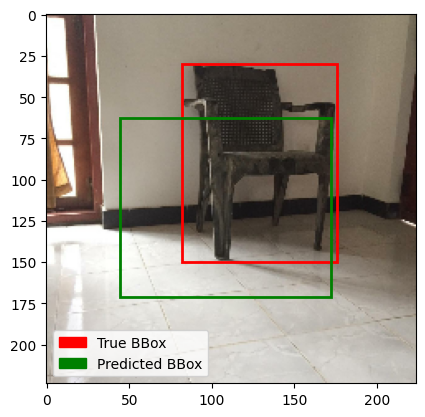

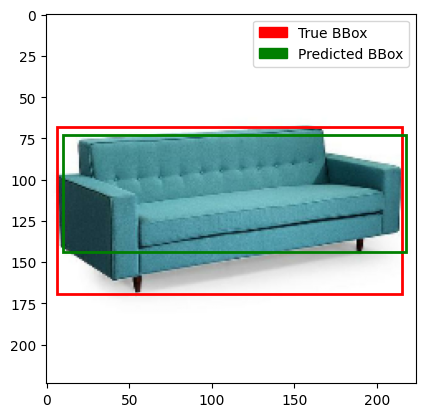

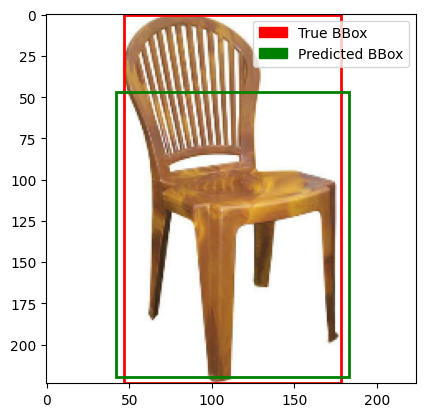

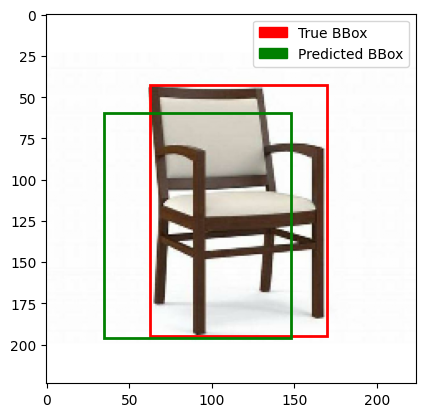

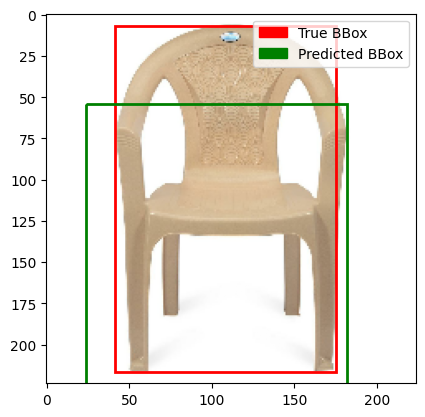

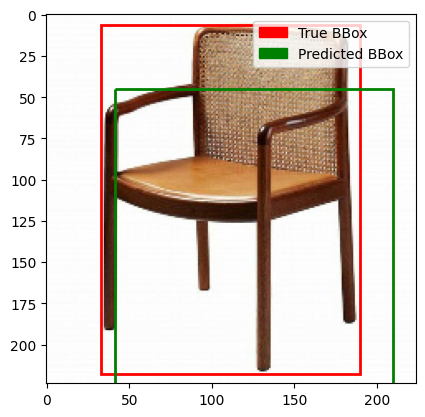

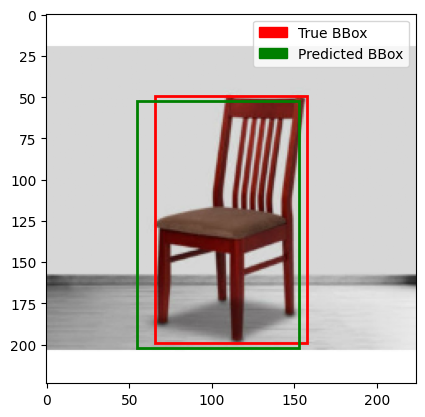

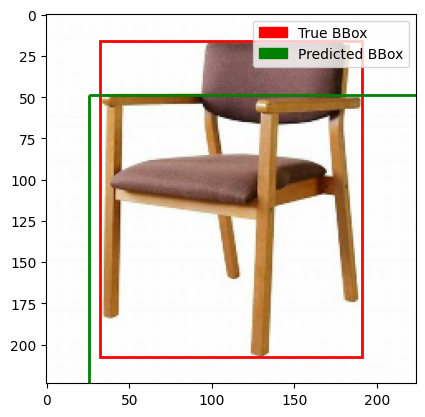

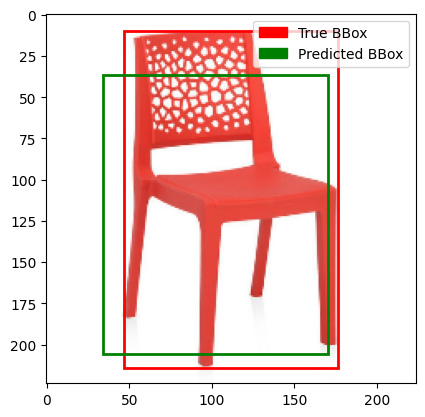

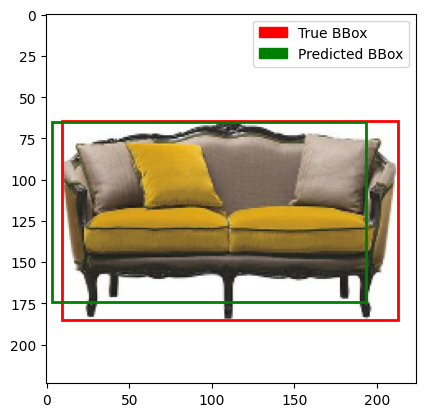

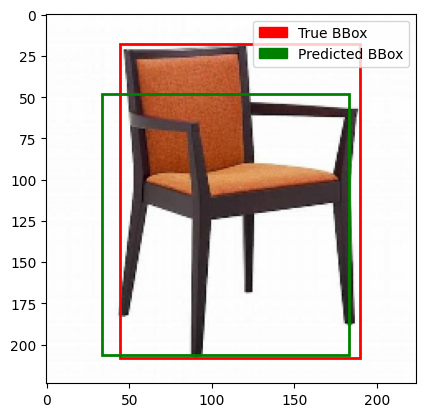

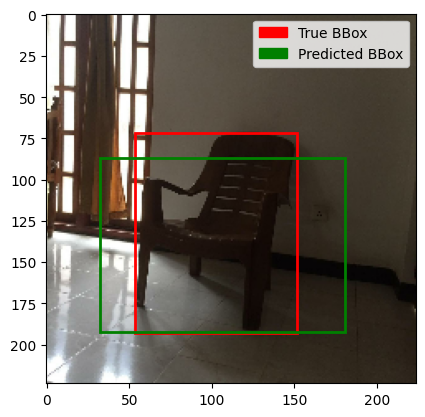

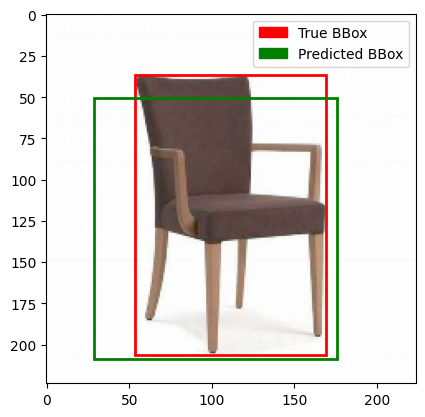

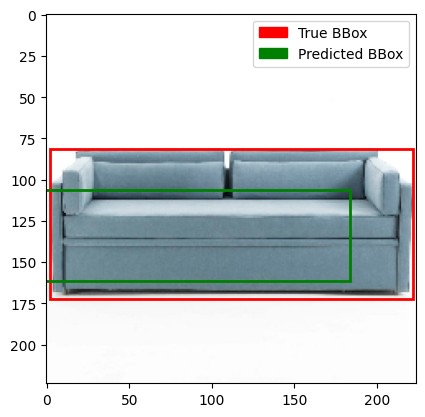

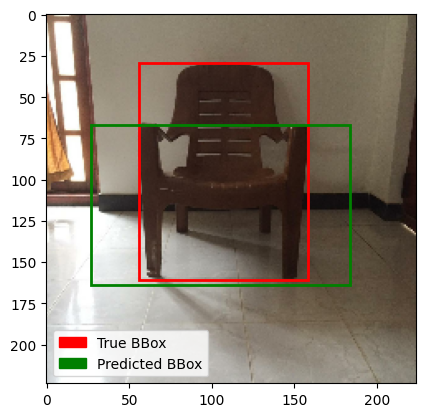

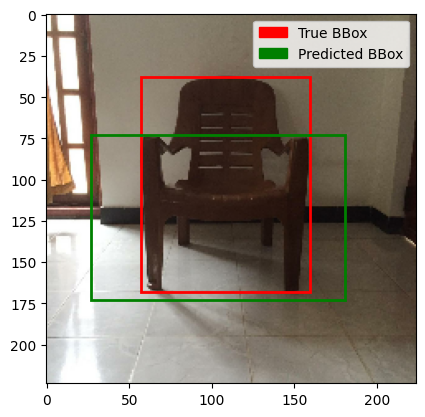

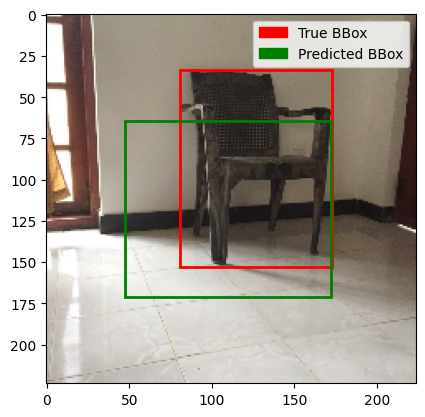

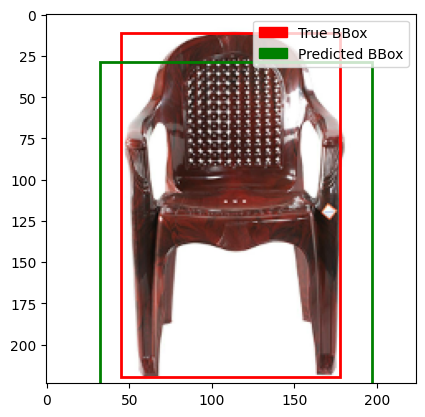

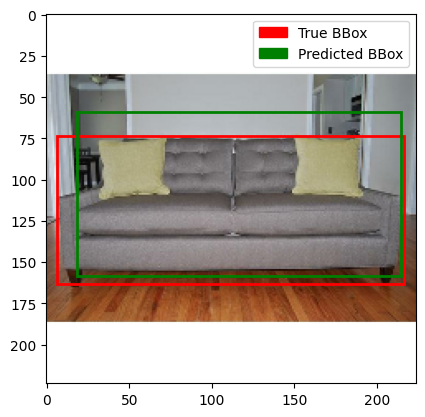

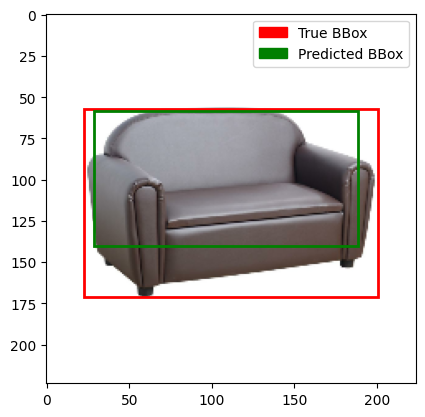

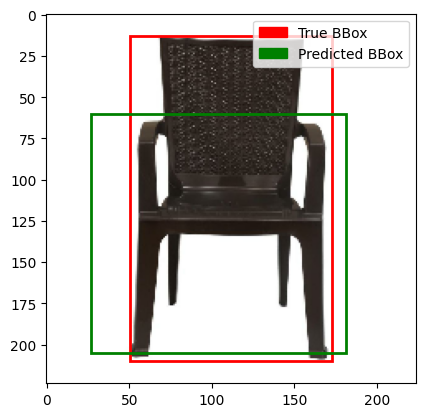

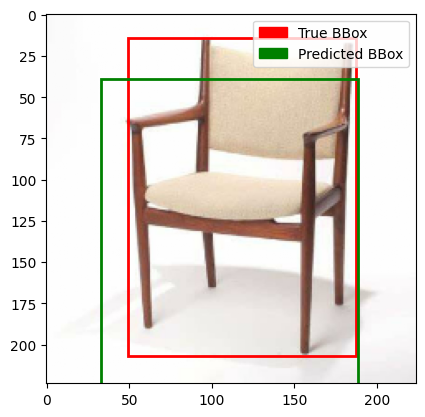

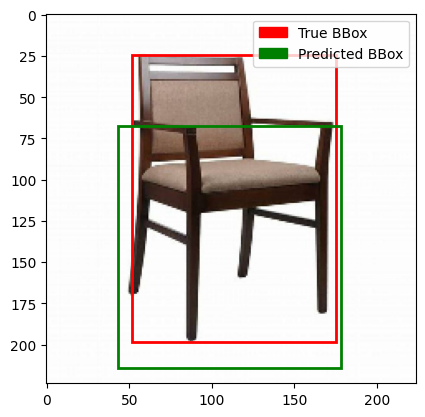

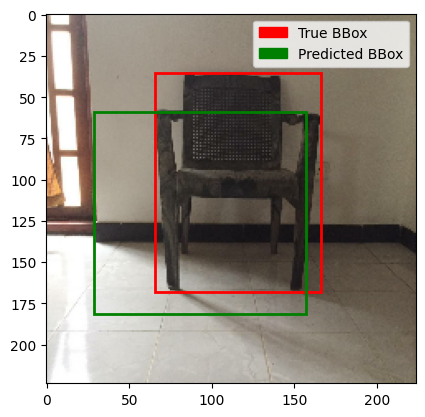

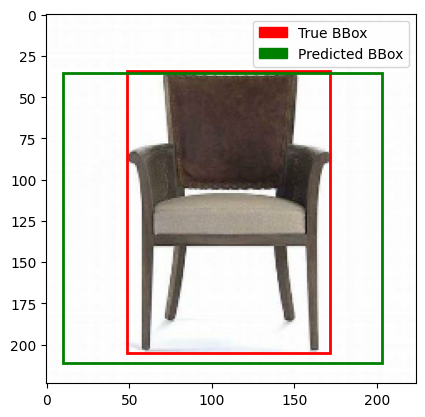

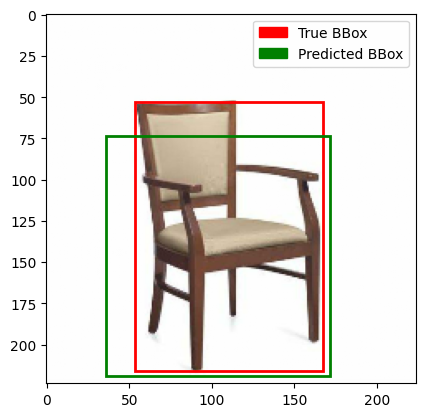

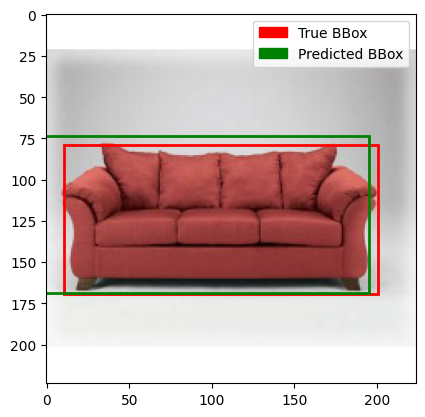

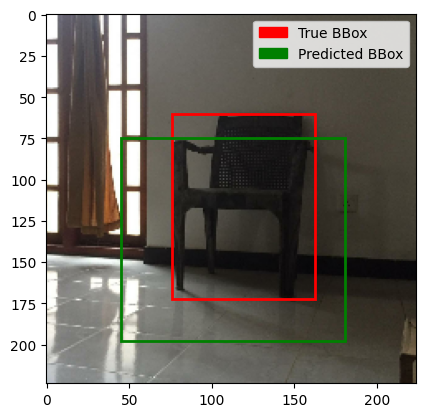

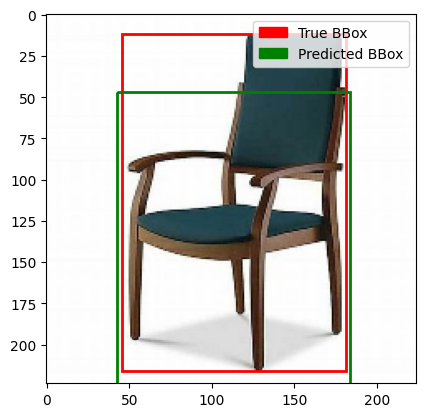

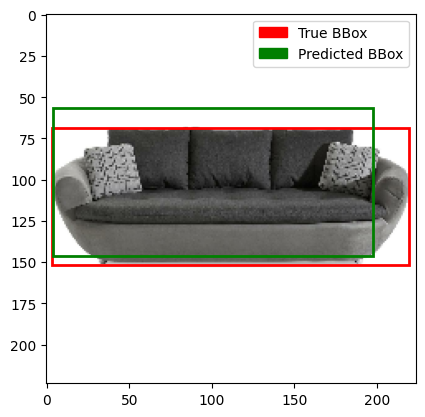

In [10]:
# Visualize some predictions
visualize_predictions(model, test_ds, num_samples=30)